# Imports

In [133]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from dotenv import load_dotenv, find_dotenv
from openai import OpenAI

import utility.utility as util
import utility.prompts as prompts

# Progress Bars:
from tqdm._tqdm_notebook import tqdm_notebook

# Below import and instructions simply for display
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# resets import once changes have been applied
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Directory and File Paths

In [42]:
path_data = os.path.join(os.getcwd(), "data")

path_stmts = os.path.join(path_data, "predict")

file_excel = os.path.join(path_data, "examples_altered.xlsx")

# Load Environment Variables

In [43]:
_ = load_dotenv(find_dotenv())

# Load Data

In [44]:
df_meta = pd.read_excel(file_excel, sheet_name="Sheet1")

# Preliminary Adjustments

In [45]:
df_meta.dropna(axis=1, inplace=True, thresh = int(df_meta.shape[0]*.1))
df_meta.drop(columns=["checked by", "new", "manual", "page (txt)", "manual", "note"], inplace=True)
df_meta["filename"] = df_meta["filename"].astype("str") + ".txt"
df_meta["filepath"] = df_meta["filename"].apply(lambda x: os.path.join(path_stmts, x))

In [46]:
#df_data.drop(columns=["path_txt", "path_doc","selected","easy",], inplace=True)
#df_data.dropna(axis=1, inplace=True, thresh = int(df_data.shape[0]*.1))
#df_data["filename"] = df_data["filename"].astype("str") + ".txt"

# Split "Train" "Test"

In [47]:
prompt_indeces = [0,1,2,3,4,5,6,7,16,17,20,21,26,27,34,35,36,37]
test_indeces = [i for i in df_meta.index if i not in prompt_indeces]

In [48]:
prompt_df = df_meta.iloc[prompt_indeces,:].copy()
test_df = df_meta.iloc[test_indeces,:].copy()
del df_meta

# Extract most common terms:

In [49]:
min_ratio = .5

terms_auditor = util.concat_terms(util.det_commonly_used_terms(prompt_df["terms_audit"], min_ratio=min_ratio), ", ")
terms_notes = util.concat_terms(util.det_commonly_used_terms(prompt_df["terms_notes"], min_ratio=min_ratio), ", ")
#terms_acc_stds = util.concat_terms(util.det_commonly_used_terms(df_meta["term"], min_ratio=0), " - ")

section_terms_auditor = prompts.common_terms_section_auditor.format(terms_auditor = terms_auditor)
section_terms_notes = prompts.common_terms_section_notes.format(terms_notes = terms_notes)
#section_terms_acc_stds = prompts.common_terms_accounting_stds.format(acc_std = terms_acc_stds)

# Construct Base Prompt

## System Context

In [51]:
system = prompts.system_context_full_task + \
         section_terms_auditor + \
         section_terms_notes + \
         prompts.instruction_1 + \
         prompts.answer_format1

In [52]:
prompt_df.columns

Index(['cc_iso3', 'year', 'filename', 'paragraph (context)', 'sentence',
       'term', 'classification', 'source', 'terms_notes', 'terms_audit',
       'filepath'],
      dtype='object')

## User_Assitant Context

In [53]:
user_assistant = prompts.get_user_assistant_context_format1(prompt_df, "filename", "source", "paragraph (context)", "sentence", "term")

## Length of Base Prompt

In [58]:
base_prompt_length = util.count_tokens(system)
for ua in user_assistant:
    base_prompt_length += util.count_tokens(ua[0])
    base_prompt_length += util.count_tokens(ua[1])

5079

# Extract Text Prompt

In [119]:
test_df = test_df[['cc_iso3', 'year', 'filename', 'paragraph (context)', 'sentence',
       'term', 'classification', 'filepath', 'source']]
df_inputs = test_df[['filepath', 'filename']].copy().drop_duplicates()

In [120]:
df_inputs['prompt'] = df_inputs['filepath'].apply(util.parse_txt).apply(util.clean_text)
df_inputs['num_tokens'] = df_inputs['prompt'].apply(util.count_tokens)
df_inputs['com_num_tokens'] = df_inputs['num_tokens'] + base_prompt_length

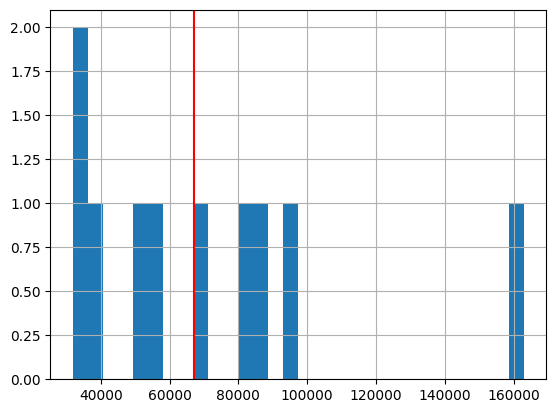

In [121]:
df_inputs['num_tokens'].hist(bins=30)
plt.axvline(x=df_inputs['com_num_tokens'].median(), color = "r")

# reduce to below 85k tokens

In [149]:
df_inputs = df_inputs[df_inputs.num_tokens <= 85000]
df_inputs

,filepath,filename,prompt,num_tokens,com_num_tokens
8,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,CEI Contract Manufacturing Limited Company Reg...,31909,36988
10,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,"Transcending Boundaries, Growing Opportunities...",38449,43528
12,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,62075442.txt,I I I I I SEC Rogi·tration Numbu I AIcI EIs I ...,69601,74680
14,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,62609130.txt,"CONTENTS TURCAS IN BRIEF Vision, Mission, Stra...",53216,58295
18,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,64866413.txt,SUMMIT SECURITIES LIMITED Corporate Identifica...,54653,59732
30,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60783048.txt,Reference Document Financial year ending This ...,82758,87837
32,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,ANNUAL REPORT & ACCOUNTS AVESCO GROUP PLC ANNU...,33859,38938


In [150]:
df_inputs['com_num_tokens']

8     36988
10    43528
12    74680
14    58295
18    59732
30    87837
32    38938
Name: com_num_tokens, dtype: int64

In [151]:
test = df_inputs.iloc[:10].copy()

In [152]:
test['com_num_tokens'].cumsum()

8      36988
10     80516
12    155196
14    213491
18    273223
30    361060
32    399998
Name: com_num_tokens, dtype: int64

# Calculate Cost

In [126]:
util.calc_price_gpt(test.shape[0], test.com_num_tokens.mean(), 1, .01, 1000)

3.99998

In [209]:
util.calc_price_gpt(100000, 16000, 3, .0005, 1000)

2400.0

# Prompt GPT

## Initialize Client

In [127]:
client = OpenAI()

## Call API

In [131]:
test['output'] = test.apply(lambda x: util.prompt_gpt(client, system, x.prompt, user_assistant, "gpt-4-0125-preview"), axis=1)

2024-03-05 14:17:19.133793
2024-03-05 14:17:34.453407
2024-03-05 14:17:51.099034
2024-03-05 14:18:16.921202
2024-03-05 14:19:00.752079
2024-03-05 14:19:29.267619
2024-03-05 14:19:50.346020


# Evaluation

In [142]:
test

,filepath,filename,prompt,num_tokens,com_num_tokens,output
8,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,CEI Contract Manufacturing Limited Company Reg...,31909,36988,ChatCompletion(id='chatcmpl-8zOxSjJW58cBKvusQH...
10,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,"Transcending Boundaries, Growing Opportunities...",38449,43528,ChatCompletion(id='chatcmpl-8zOxhiDBiBO6hvVSyb...
12,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,62075442.txt,I I I I I SEC Rogi·tration Numbu I AIcI EIs I ...,69601,74680,ChatCompletion(id='chatcmpl-8zOxzpwmdkcVGsM0bs...
14,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,62609130.txt,"CONTENTS TURCAS IN BRIEF Vision, Mission, Stra...",53216,58295,ChatCompletion(id='chatcmpl-8zOyOH6jzVrIhCJb6o...
18,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,64866413.txt,SUMMIT SECURITIES LIMITED Corporate Identifica...,54653,59732,ChatCompletion(id='chatcmpl-8zOz65W4RtpCOo5N8z...
30,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60783048.txt,Reference Document Financial year ending This ...,82758,87837,ChatCompletion(id='chatcmpl-8zOzZ96eeOaRxmcbmG...
32,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,ANNUAL REPORT & ACCOUNTS AVESCO GROUP PLC ANNU...,33859,38938,ChatCompletion(id='chatcmpl-8zOztkopOfdPteSVpY...


In [146]:
for row in test.index:
    print(test.loc[row].filename, test.loc[row]["output"].choices[0].message.content)
    print()

61466756.txt {
  "Notes": {
    "sentence": "['The financial report is a general purpose financial report which has been prepared in accordance with Australian\nAccounting Standards (\u201cAASBs\u201d) adopted by the Australian Accounting Standards Board (\u201cAASB\u201d) and the\nCorporations Act 2001. International Financial Reporting Standards (\u201cIFRSs\u201d) form the basis of Australian Accounting\nStandards (\u201cAASBs\u201d) adopted by the AASB, and for the purpose of this report are called Australian equivalents to IFRS\n(\u201cAIFRS\u201d) to distinguish from previous Australian GAAP.']",
    "standard": "['Australian Accounting Standards (\u201cAASBs\u201d) adopted by the Australian Accounting Standards Board (\u201cAASB\u201d) and the\nCorporations Act 2001']"
  },
  "Auditor": {
    "sentence": "['complying with Australian Accounting Standards and the Corporations Regulations 2001; and']",
    "standard": "['Australian Accounting Standards and the Corporations Regulati

In [139]:
files = test.filename.values
labels = test_df[test_df.filename.isin(files)]

In [148]:
labels['cc_iso3 filename sentence term source'.split()]

,cc_iso3,filename,sentence,term,source
8,SGP,61466756.txt,"In our opinion, the the consolidated financial...",Singapore Financial Reporting Standards,audit
9,SGP,61466756.txt,The consolidated financial statements of the ...,Singapore Financial Reporting Standards (“FRS”),notes
10,SGP,61511488.txt,"In our opinion, the financial statements of t...",Singapore Financial Reporting Standards,audit
11,SGP,61511488.txt,The consolidated financial statements of the G...,"Singapore Financial Reporting Standards (""FRS"")",notes
12,PHL,62075442.txt,The consolidated fmancial statements have bee...,Philippine Financial Reporting Standards (PFR...,notes
13,PHL,62075442.txt,"In our opinion, the consolidated financial sta...",Philippine Financial Reporting Standards.,audit
14,TUR,62609130.txt,the consolidated financial statements present ...,Turkish Accounting Standards.,audit
15,TUR,62609130.txt,The accompanying consolidated financial statem...,Turkish Accounting Standards,notes
18,IND,64866413.txt,These consolidated financial statements have b...,Generally Accepted Accounting \nPrinciples in ...,notes
19,IND,64866413.txt,the aforesaid \nstandalone financial statement...,accounting principles generally \naccepted in ...,audit
